In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [18]:
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/eqtl/matched/leafcutter"

In [35]:
models = [
    "CADD.RawScore",
    #"phyloP",
    #"phastCons",
    "phyloP-Zoonomia",
    "SpliceAI",
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression",
    #"LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
]

embedding_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    "LongSafari/hyenadna-large-1m-seqlen-hf",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,gene_id,exon_dist,match_group,CADD,phyloP-241-mammals,SpliceAI,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
0,1,690060,A,C,0.994126,0.038760,True,ENSG00000284662,3406,0,-0.474637,NaN,NaN,-0.403703,-0.326945,-0.366080,-0.366930
1,1,841166,A,G,1.000000,0.243043,True,ENSG00000187634,82755,1,-0.185041,-0.253,NaN,-0.435982,-0.718777,-0.453756,-0.487090
2,1,917495,C,T,0.905950,0.420123,True,ENSG00000187634,6426,2,-1.199292,-4.459,NaN,-0.825194,-0.770590,-0.744893,-0.899335
3,1,920949,C,G,0.915184,0.169975,True,ENSG00000187634,2972,3,0.000004,0.588,NaN,-0.729373,-0.735926,-0.750730,-0.744050
4,1,946870,C,A,1.000000,0.036384,True,ENSG00000188976,325,4,0.134136,0.186,-0.03,-0.563996,-0.665406,-0.607035,-0.637817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,X,154843392,C,T,0.009303,0.017241,False,ENSG00000185010,5640,8950,-0.331509,-0.134,-0.00,-0.443707,-0.170278,-0.390702,-0.379164
17992,X,154864799,G,A,0.009303,0.017241,False,ENSG00000185010,1572,8909,0.033722,-0.680,-0.00,-0.391480,-0.304395,-0.297630,-0.454497
17993,X,154900519,G,C,0.009303,0.017241,False,ENSG00000185010,568,8908,0.556777,4.428,-0.00,-0.272337,-0.447172,-0.335100,-0.358643
17994,X,155264893,T,C,0.009922,0.281606,False,ENSG00000155961,402,8846,0.360310,0.279,NaN,-0.146626,-0.427843,-0.189941,-0.295209


In [36]:
V.dropna(
    subset=models,
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,gene_id,exon_dist,match_group,CADD,phyloP-241-mammals,SpliceAI,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
4,1,946870,C,A,1.000000,0.036384,True,ENSG00000188976,325,4,0.134136,0.186,-0.03,-0.563996,-0.665406,-0.607035,-0.637817
5,1,954496,C,G,0.996345,0.015265,True,ENSG00000188976,414,5,0.096380,-0.057,-0.00,-0.679605,-0.705959,-0.622280,-0.671091
6,1,958339,G,A,0.955819,0.092703,True,ENSG00000188976,588,6,-0.001602,0.413,-0.00,-0.475691,-0.744037,-0.525854,-0.607300
7,1,973443,G,A,0.999930,0.164754,True,ENSG00000187583,55,7,-0.371230,-0.071,-0.02,-0.623791,-0.896441,-0.781444,-0.791981
8,1,973693,C,T,0.994036,0.368690,True,ENSG00000187583,53,8,0.494063,3.215,-0.02,-0.663721,-0.877497,-0.761169,-0.837160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17982,X,153931677,C,T,0.007914,0.246032,False,ENSG00000102030,392,8844,0.160316,0.562,-0.00,-0.672113,-0.702652,-0.738007,-0.704919
17988,X,154477925,C,G,0.906906,0.163367,True,ENSG00000196976,0,8994,0.174134,0.207,-0.00,-0.673705,-0.642400,-0.736945,-0.667853
17991,X,154843392,C,T,0.009303,0.017241,False,ENSG00000185010,5640,8950,-0.331509,-0.134,-0.00,-0.443707,-0.170278,-0.390702,-0.379164
17992,X,154864799,G,A,0.009303,0.017241,False,ENSG00000185010,1572,8909,0.033722,-0.680,-0.00,-0.391480,-0.304395,-0.297630,-0.454497


In [37]:
V = V[V.duplicated("match_group", keep=False)]
V.label.value_counts()

label
True     4880
False    4880
Name: count, dtype: int64

## Testing

In [38]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC])
results = pd.DataFrame(rows, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

100%|██████████| 7/7 [00:00<00:00, 110.84it/s]


,Model,AUROC
4,InstaDeepAI/nucleotide-transformer-2.5b-multi-...,0.738014
6,multiz100way/89/512/256/True/defined.phastCons...,0.718454
5,multiz100way/89/256/128/True/defined.phastCons...,0.713361
3,multiz100way/89/128/64/True/defined.phastCons....,0.704355
2,SpliceAI,0.628237
0,CADD,0.544705
1,phyloP-241-mammals,0.510632


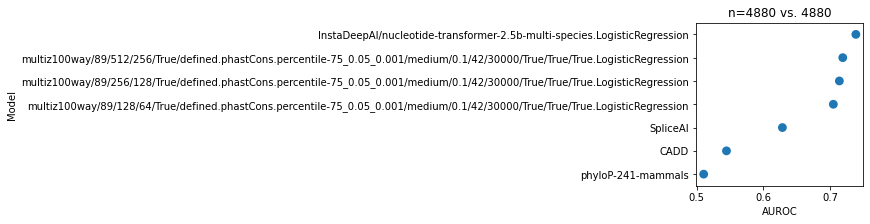

In [39]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);